***
### Import of required libraries
***

In [1]:
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model

from traffic.core import Traffic

2024-05-31 16:04:42.243437: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-31 16:04:42.403558: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-31 16:04:42.403593: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-31 16:04:42.404165: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-31 16:04:42.478658: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-31 16:04:42.480726: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

***
### Import of data, model and scalers
***

##### Data

In [2]:
test_in_con = np.load("/mnt/beegfs/store/krum/MT/samples/test_in32_con.npy")
test_in_var = np.load("/mnt/beegfs/store/krum/MT/samples/test_in32_var.npy")
test_out = np.load("/mnt/beegfs/store/krum/MT/samples/test_out32.npy")

# temp, to be removed -> change from 36 to 37 timesteps
test_out = test_out[:, :36, :]

##### Model

In [3]:
def rmse_lat():
    return None


def rmse_lon():
    return None


def rmse_alt():
    return None


model = load_model(
    f"/home/krum/git/MT_krum_code/models/helpful-tree-123.keras",
    custom_objects={
        "rmse_lat": rmse_lat,
        "rmse_lon": rmse_lon,
        "rmse_alt": rmse_alt,
        "weighted_mse": tf.keras.losses.MeanSquaredError(),
    },
)

##### Scalers

In [4]:
# scaler_in
with open(
    "/mnt/beegfs/store/krum/MT/encoded_scaled_split/scaler_in.pkl",
    "rb",
) as file:
    scaler_in = pickle.load(file)

# scaler_out
with open(
    "/mnt/beegfs/store/krum/MT/encoded_scaled_split/scaler_out.pkl",
    "rb",
) as file:
    scaler_out = pickle.load(file)

***
### Application of model to get prediction on test set
***

##### Model application

In [ ]:
# to be uncommented !
# prediction = model.predict((test_in_var, test_in_con))

In [5]:
# # Temp, to be removed !
# np.save(
#     f"/home/krum/git/MT_krum_code/03_analysis/predictions_with_mass.npy",
#     prediction,
# )
prediction = np.load(
    f"/home/krum/git/MT_krum_code/03_analysis/predictions_with_mass.npy",
)

##### Unscaling

In [6]:
# Predictions
prediction_unscaled = scaler_out.inverse_transform(
    prediction.reshape(-1, 3)
).reshape(-1, 36, 3)[:, 1:, :]

# True values
test_out_unscaled = scaler_out.inverse_transform(
    test_out.reshape(-1, 3)
).reshape(-1, 36, 3)[:, 1:, :]

***
### Analysis of altitude prediction error
***

##### Error calculation

In [28]:
# Computation of altitude error and conversion from feet to meters
altitude_diff_m = (
    prediction_unscaled[:, :, 2] - test_out_unscaled[:, :, 2]
) / 3.281

##### Visualisation

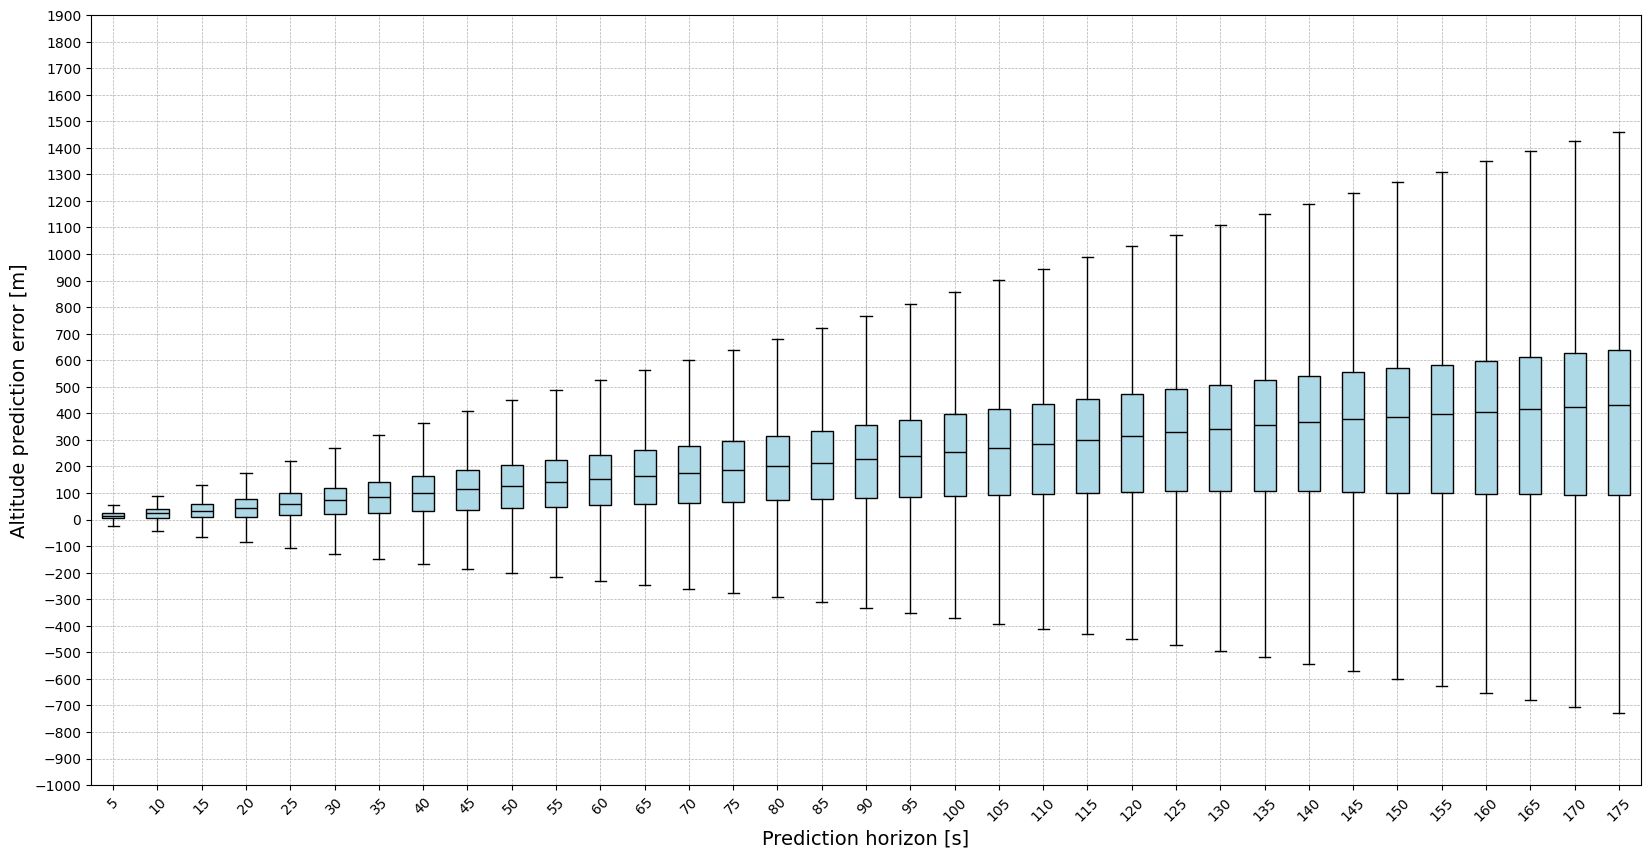

In [30]:
# Generate boxplots
plt.figure(figsize=(20, 10))

# Create boxplot for each timestep (prediction horizon)
plt.boxplot(
    [altitude_diff_m[:, i] for i in range(35)],
    positions=range(35),
    patch_artist=True,
    boxprops=dict(facecolor="lightblue", color="black"),
    medianprops=dict(color="black"),
    whiskerprops=dict(color="black"),
    capprops=dict(color="black"),
    showfliers=False,
)

# Set plot axis labels and ticks
plt.xlabel("Prediction horizon [s]", fontsize=14)
plt.ylabel("Altitude prediction error [m]", fontsize=14)
plt.xticks(
    ticks=range(0, 35, 1),
    labels=[str(i) for i in range(5, 180, 5)],
    rotation=45,
)
plt.yticks(ticks=np.arange(-1000, 2000, 100))

# Set grid
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.gca().patch.set_alpha(0.3)

# Show plot
plt.show()

***
### Analysis of position prediction error
***

##### Error calculation

In [10]:
# Extraction of latitudes and longitudes
pred_lat = prediction_unscaled[:, :, 0].flatten()
pred_lon = prediction_unscaled[:, :, 1].flatten()
test_lat = test_out_unscaled[:, :, 0].flatten()
test_lon = test_out_unscaled[:, :, 1].flatten()

# Computation of latitude and longitude errors
lat_error = (pred_lat - test_lat).reshape(prediction_unscaled.shape[0], 35)
lon_error = (pred_lon - test_lon).reshape(prediction_unscaled.shape[0], 35)


# Computation of 2d position errors [m]
def haversine(lat1, lon1, lat2, lon2):
    lon1, lat1, lon2, lat2 = np.radians([lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    haver_formula = (
        np.sin(dlat / 2) ** 2
        + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    )

    r = 6371
    dist = 2 * r * np.arcsin(np.sqrt(haver_formula))
    return dist


position_error_m = (
    haversine(
        pred_lat,
        pred_lon,
        test_lat,
        test_lon,
    ).reshape(prediction_unscaled.shape[0], 35)
    * 1000  # km to m
)

##### Visualisation latitude error

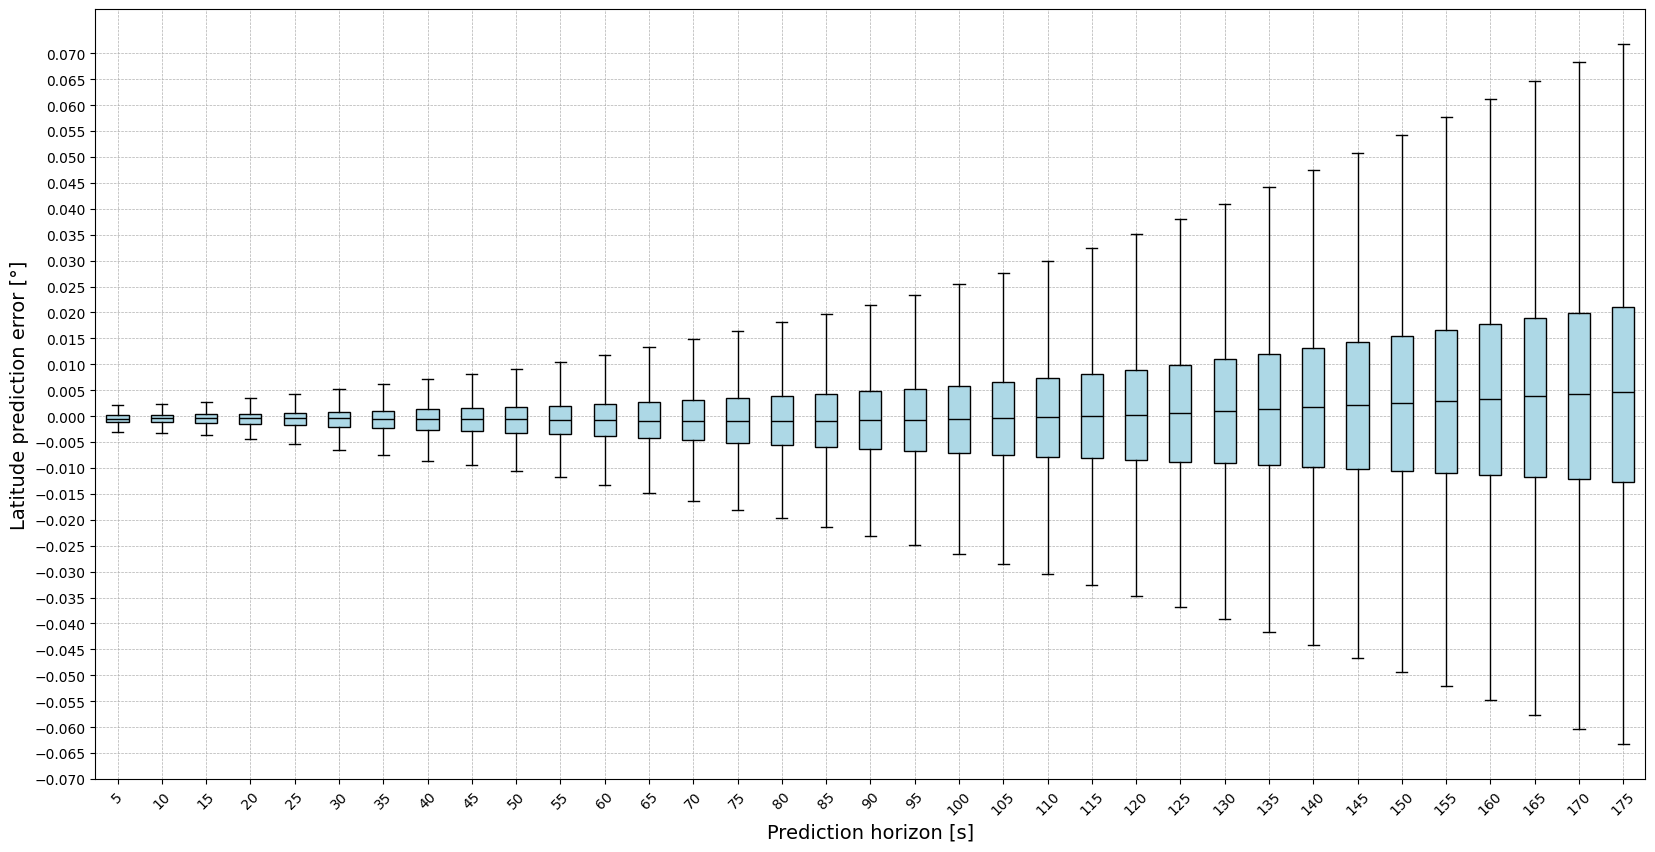

In [14]:
# Generate boxplots
plt.figure(figsize=(20, 10))

# Create boxplot for each timestep (prediction horizon)
plt.boxplot(
    [lat_error[:, i] for i in range(35)],
    positions=range(35),
    patch_artist=True,
    boxprops=dict(facecolor="lightblue", color="black"),
    medianprops=dict(color="black"),
    whiskerprops=dict(color="black"),
    capprops=dict(color="black"),
    showfliers=False,
)

# Set plot axis labels and ticks
plt.xlabel("Prediction horizon [s]", fontsize=14)
plt.ylabel("Latitude prediction error [°]", fontsize=14)
plt.xticks(
    ticks=range(0, 35, 1),
    labels=[str(i) for i in range(5, 180, 5)],
    rotation=45,
)
plt.yticks(ticks=np.arange(-0.07, 0.07, 0.005))

# Set grid
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.gca().patch.set_alpha(0.3)

# Show plot
plt.show()

##### Visualisation longitude error

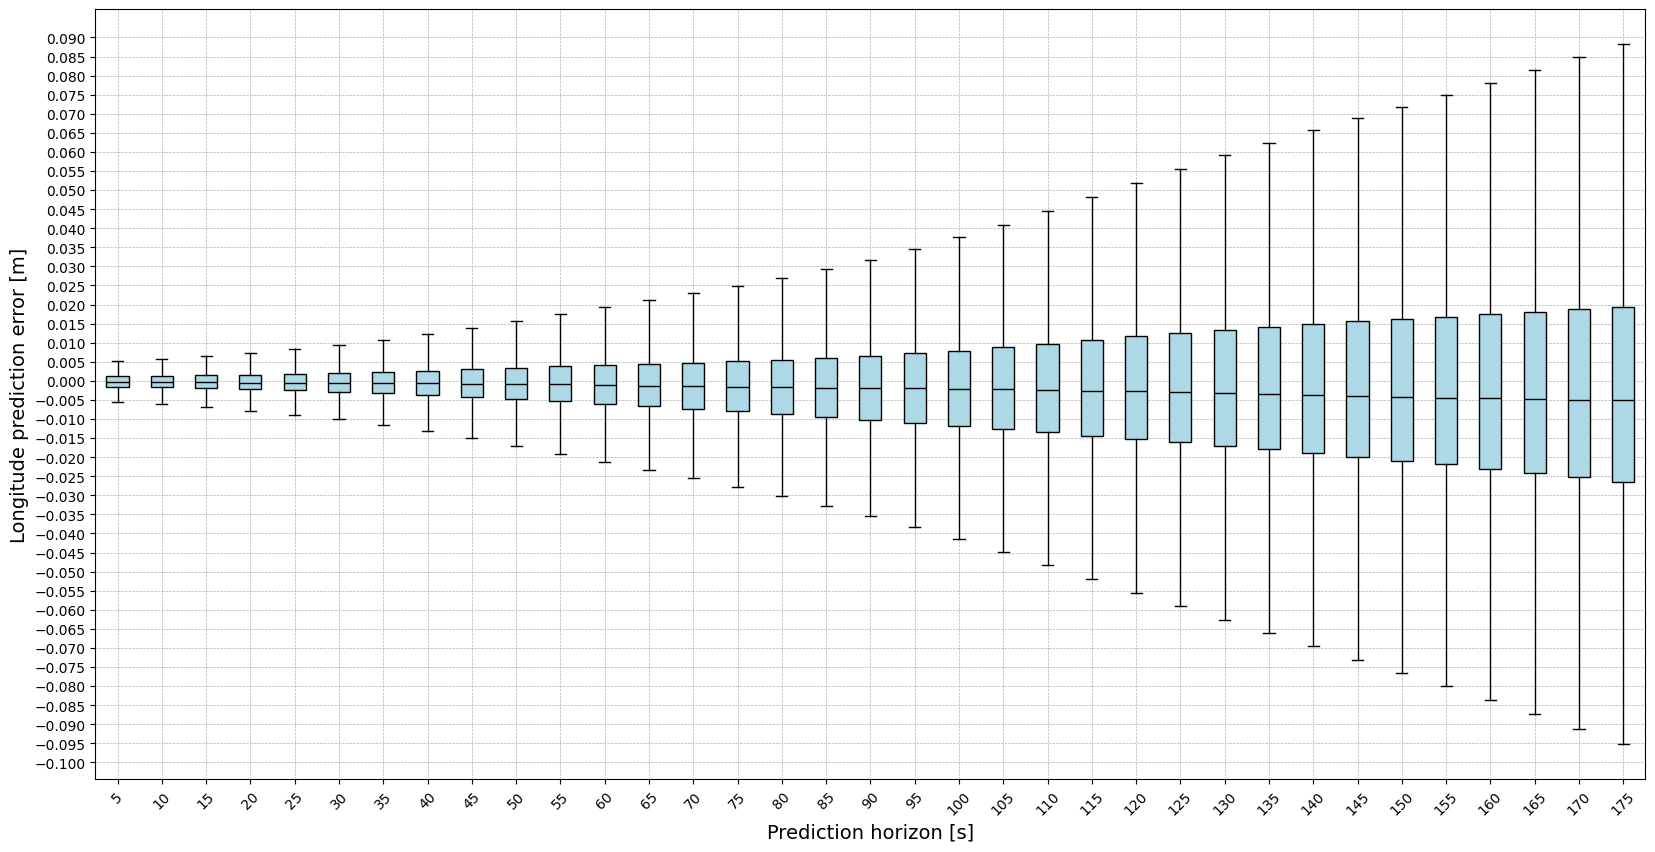

In [19]:
# Generate boxplots
plt.figure(figsize=(20, 10))

# Create boxplot for each timestep (prediction horizon)
plt.boxplot(
    [lon_error[:, i] for i in range(35)],
    positions=range(35),
    patch_artist=True,
    boxprops=dict(facecolor="lightblue", color="black"),
    medianprops=dict(color="black"),
    whiskerprops=dict(color="black"),
    capprops=dict(color="black"),
    showfliers=False,
)

# Set plot axis labels and ticks
plt.xlabel("Prediction horizon [s]", fontsize=14)
plt.ylabel("Longitude prediction error [m]", fontsize=14)
plt.xticks(
    ticks=range(0, 35, 1),
    labels=[str(i) for i in range(5, 180, 5)],
    rotation=45,
)
plt.yticks(ticks=np.arange(-0.1, 0.095, 0.005))

# Set grid
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.gca().patch.set_alpha(0.3)

# Show plot
plt.show()

##### Visualisation of 2d position error

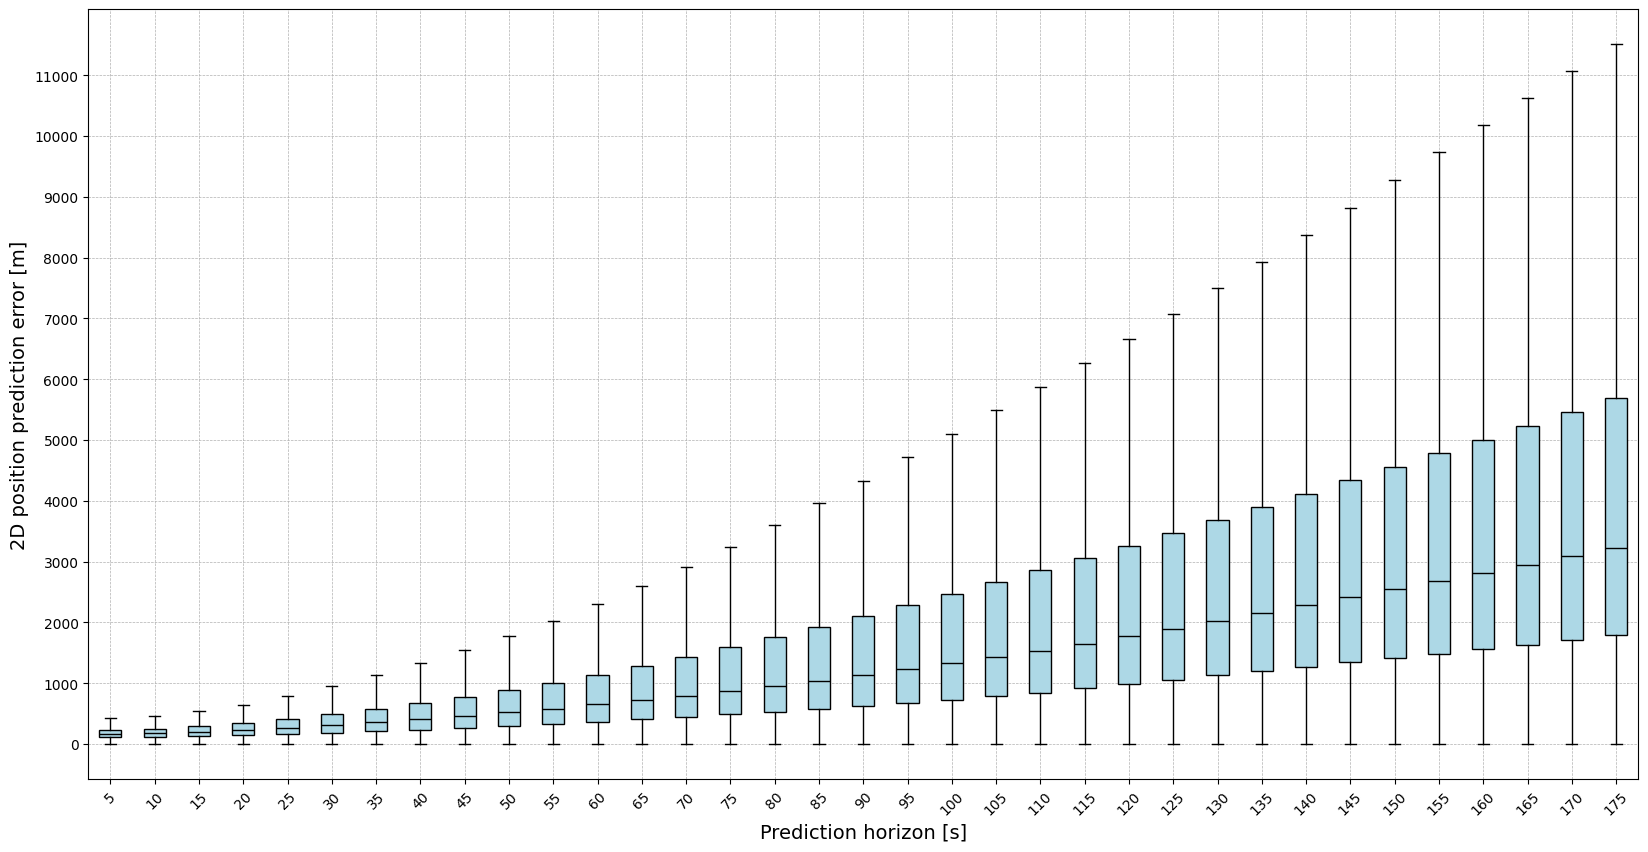

In [20]:
# Generate boxplots
plt.figure(figsize=(20, 10))

# Create boxplot for each timestep (prediction horizon)
plt.boxplot(
    [position_error_m[:, i] for i in range(35)],
    positions=range(35),
    patch_artist=True,
    boxprops=dict(facecolor="lightblue", color="black"),
    medianprops=dict(color="black"),
    whiskerprops=dict(color="black"),
    capprops=dict(color="black"),
    showfliers=False,
)

# Set plot axis labels and ticks
plt.xlabel("Prediction horizon [s]", fontsize=14)
plt.ylabel("2D position prediction error [m]", fontsize=14)
plt.xticks(
    ticks=range(0, 35, 1),
    labels=[str(i) for i in range(5, 180, 5)],
    rotation=45,
)
plt.yticks(ticks=np.arange(0, 12000, 1000))

# Set grid
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.gca().patch.set_alpha(0.3)

# Show plot
plt.show()